In [ ]:
!pip install yfinance
import yfinance as yf

from math import log,e
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
clear_output()

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 16})

In [ ]:
def black_scholes_merton(stock_price, strike_price, rate, time, volatility, dividend=0.0):

  '''Function that estimates the value of a call and put option using the Black Scholes Merton Model.
  
  Parameters
  ----------
  stock_price: Spot market value of the underlying asset
  strike_price: Strike price of the options contract
  rate: Risk free rate
  time: Time to expiration for the options contract
  volatility: Volatility of the asset
  dividend: Dividend or yield of the asset, with a default value set to zero

  Returns
  -------
  [call,put]: Returns a list containing the estimated call and put value of the option contract
  '''

  d1 = (log(stock_price/strike_price) + (rate - dividend + volatility**2/2) * time)/(volatility * time**.5)
  d2 = d1 - volatility * time**.5

  call = stats.norm.cdf(d1) * stock_price*e**(-dividend*time) - stats.norm.cdf(d2)*strike_price*e**(-rate*time)
  put = stats.norm.cdf(-d2)*strike_price*e**(-rate * time) - stats.norm.cdf(-d1) * stock_price*e**(-dividend*time)

  return [call, put]

# **Collar Strategy**

**A collar strategy is executed by selling a call option on an underlying asset that is held in the portfolio and simultaneously purchasing a protective put. The net profit from the strategy is the premium collected for selling the call option subtracted by the cost of purchasing a put. This makes the collar strategy a combination of a covered call and protective put.**

**The collar strategy clearly defines the potential maximum gain and loss. If the underlying asset rises above the strike price of the call option the asset is called away and the maximum value of the position is the strike price of the call plus the net premium of the strategy. If the underlying asset falls below the put's strike price, the minimum value of the position is the strike price of the put plus the net premium paid.**

## **Scenario: You are a portfolio manager and hold 100 shares of Apple (Ticker: AAPL). You forecast that the price will fall, but you do not want to pay for a put option outright. Instead you plan to sell a covered call to purchase a protective put, simulating a collar strategy.**

In [ ]:
aapl = yf.Ticker('AAPL')
aapl_price = aapl.get_info()['previousClose']
sk_price_call = 180
sk_price_put = 160
rf_rate = yf.Ticker('^TNX').get_info()['previousClose']*.01
ivol = 0.30
t = 0.5
div_yield = aapl.get_info()['dividendYield']

print(f'Apple Stock Previously Closed at: {aapl_price}')

Apple Stock Previously Closed at: 172.19


In [ ]:
call = black_scholes_merton(stock_price=aapl_price,
                     strike_price=sk_price_call,
                     rate=rf_rate, 
                     time=t, 
                     volatility=ivol, 
                     dividend=div_yield)[0]

put = black_scholes_merton(stock_price=aapl_price,
                     strike_price=sk_price_put,
                     rate=rf_rate, 
                     time=t, 
                     volatility=ivol, 
                     dividend=div_yield)[1]

net_premium = (call-put)

print(f'The BSM estimate for a 6 month AAPL call option is: ${100*call:.2f}\nThe BSM estimate for a 6 month AAPL put option is: ${100*put:.2f}\nThe net premium from the collar strategy is: ${100*net_premium:.2f}')

The BSM estimate for a 6 month AAPL call option is: $1167.40
The BSM estimate for a 6 month AAPL put option is: $835.94
The net premium from the collar strategy is: $331.46


In [ ]:
aapl_portfolio = aapl_price * 100
print(f'The current value of AAPL holdings is: ${aapl_portfolio}')

The current value of AAPL holdings is: $17219.0


In [ ]:
stock_price = np.arange(125,225,.1)

In [ ]:
collar_list = []

for stock in stock_price:
  if stock > sk_price_call:
    #price at which shares get called from selling call option
    collar_list.append((sk_price_call+net_premium)*100)
  elif stock < sk_price_put:
    #price at which shares would be sold using the protective put
    collar_list.append((sk_price_put+net_premium)*100)
  else:
    collar_list.append((stock+net_premium)*100)

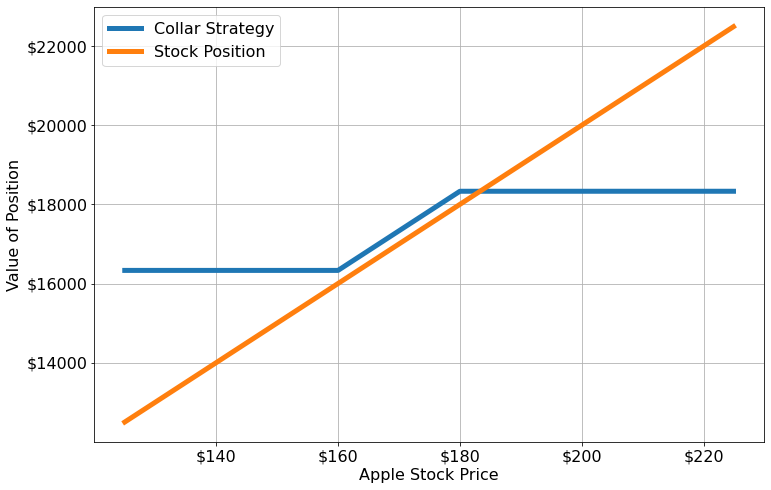

In [ ]:
plt.plot(np.arange(125,225,.1),collar_list,label='Collar Strategy',lw=5)
plt.plot(stock_price,stock_price*100,label='Stock Position',lw=5)

pl_label = ['$'+str(price) for price in range(14000,24000,2000)]
plt.yticks(range(14000,24000,2000),pl_label)
plt.ylabel('Value of Position')
appl_label = ['$'+str(price) for price in range(140,240,20)]
plt.xticks(range(140,240,20),appl_label)
plt.xlabel('Apple Stock Price')
plt.grid()
plt.legend();

In [ ]:
def collar_strategy(ticker,sk_price_c,sk_price_p,implied_vol,time_to_expiry,quantity):
  st = yf.Ticker(ticker.upper())
  st_price = st.get_info()['previousClose']
  rf_rate = yf.Ticker('^TNX').get_info()['previousClose']*.01
  div_yield = aapl.get_info()['dividendYield']

  price_range = np.arange(st_price*.75,st_price*1.30,.1)
  c = black_scholes_merton(stock_price=st_price,strike_price=sk_price_c,rate=rf_rate, time=time_to_expiry, volatility=implied_vol, dividend=div_yield)[0]
  p = black_scholes_merton(stock_price=st_price,strike_price=sk_price_p,rate=rf_rate, time=time_to_expiry, volatility=implied_vol, dividend=div_yield)[1]
  net_p = (c-p)
  

  collar_strat = []
  for stock in price_range:
    if stock > sk_price_c:
      #price at which shares get called from selling call option
      collar_strat.append((sk_price_c+net_p)*100*quantity)
    elif stock < sk_price_p:
      #price at which shares would be sold using the protective put
      collar_strat.append((sk_price_p+net_p)*100*quantity)
    else:
      collar_strat.append((stock+net_p)*100*quantity)

  #plotting
  plt.plot(price_range,collar_strat,label='Collar Strategy',lw=5)
  plt.plot(price_range,price_range*100*quantity,label='Stock Position',lw=5)
  plt.ylabel('Value of Position')
  plt.xlabel('Stock Price')
  plt.grid()
  plt.legend();

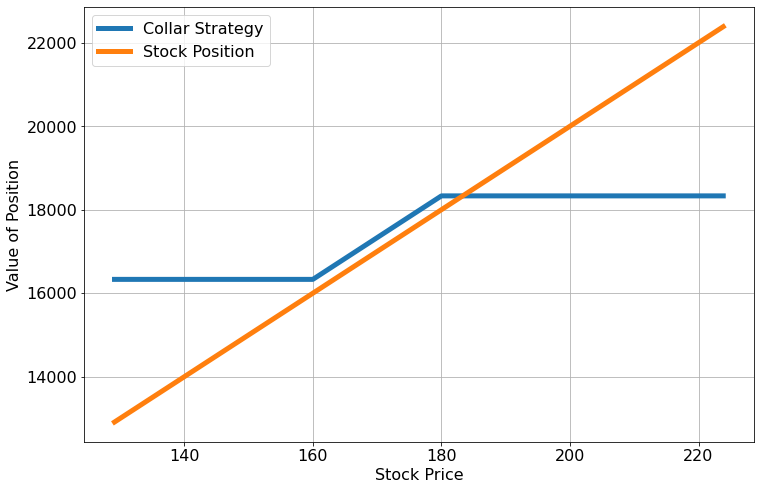

In [ ]:
collar_strategy(ticker='AAPL',
                sk_price_c=sk_price_call,
                sk_price_p=sk_price_put,
                implied_vol=ivol,
                time_to_expiry=t,
                quantity=1)

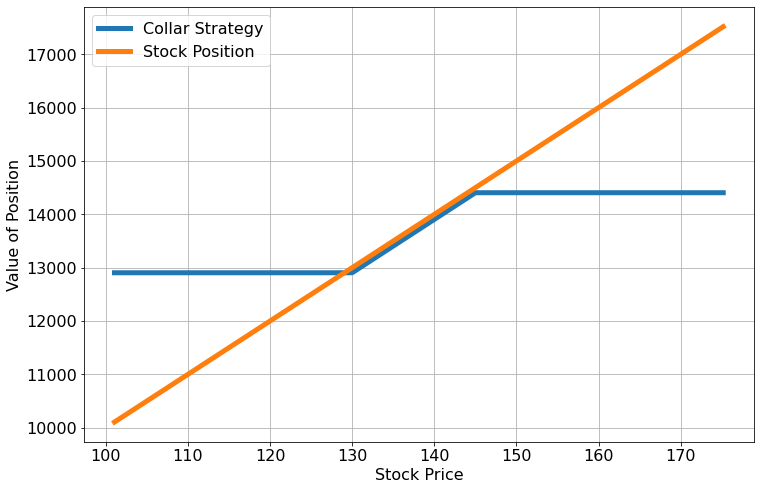

In [ ]:
collar_strategy(ticker='ibm',
                sk_price_c=145,
                sk_price_p=130,
                implied_vol=.25,
                time_to_expiry=0.5,
                quantity=1)

# **References and Additional Learning**

## **Textbook**

- **[Options, Futures, and Other Derivatives, 10th Edition](https://www.pearson.com/us/higher-education/program/Hull-Options-Futures-and-Other-Derivatives-10th-Edition/PGM333301.html)**

## **Videos**

- **[Black Scholes Merton option pricing model](https://www.youtube.com/watch?v=sbdba4AB5JM&ab_channel=BionicTurtle) from Bionic Turle**

- **[Simple option trading strategies: an option plus the underlying asset](https://www.youtube.com/watch?v=Ee8gJLGkcY8&t=105s&ab_channel=BionicTurtle) from Bionic Turtle**

## **Websites**

- **[Input parameter for Stock Price and Dividend Yield](https://finance.yahoo.com/quote/AAPL?p=AAPL&.tsrc=fin-srch) from Yahoo! Finance**

- **[Input parameter for Implied Volatility and Time](https://finance.yahoo.com/quote/AAPL/options?date=1645142400) from Yahoo! Finance**

- **[Black-Scholes Model](https://www.investopedia.com/terms/b/blackscholes.asp) by Adam Hayes from Investopedia.com**

- **[European Option](https://www.investopedia.com/terms/e/europeanoption.asp) from Investopedia.com**

# **Connect**
- **Feel free to connect with Adrian on [YouTube](https://www.youtube.com/channel/UCPuDxI3xb_ryUUMfkm0jsRA), [LinkedIn](https://www.linkedin.com/in/adrian-dolinay-frm-96a289106/), [Twitter](https://twitter.com/DolinayG) and [GitHub](https://github.com/ad17171717). Happy coding!**